# Analytical process simulation

The simplest (and quickest) process simulation involves analytical implant tables, followed by broadening of the profile according to a tabulated diffusion coefficient. 

The implant module of gdsfactory tabulates these expressions for silicon and common implants, and allows you to import them to TCAD solvers.

For more exact implant simulation, see the numerical implantation and numerical diffusion modules.

References:

[1] Selberherr, S. (1984). Process Modeling. In: Analysis and Simulation of Semiconductor Devices. Springer, Vienna. https://doi.org/10.1007/978-3-7091-8752-4_3

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from gdsfactory.simulation.process.implant_tables import *

2023-02-20 17:58:55.612 | INFO     | gdsfactory.config:<module>:50 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 6.43.1


## Gaussian profile

The simplest approximation to an implantation profile only considers the range (mean) and straggle (standard deviation) of the ion distribution:

Text(0.5, 1.0, 'Ion implantation in silicon, range')

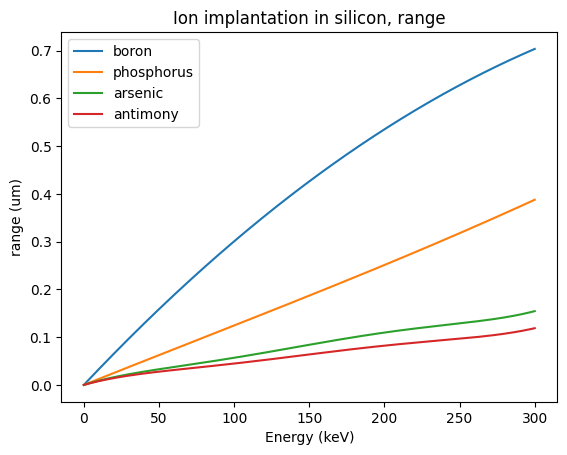

In [2]:
energies = np.linspace(0, 300, 1000)  # keV

for dopant in ["boron", "phosphorus", "arsenic", "antimony"]:
    plt.plot(energies, depth_in_silicon[dopant](energies), label=dopant)

plt.xlabel("Energy (keV)")
plt.ylabel("range (um)")
plt.legend(loc="best")
plt.title("Ion implantation in silicon, range")

Text(0.5, 1.0, 'Ion implantation in silicon, straggle')

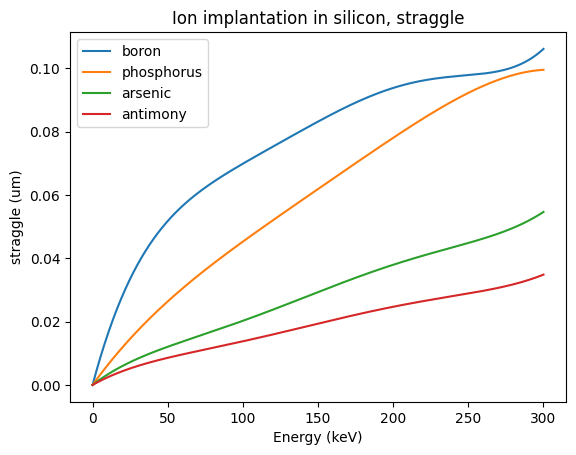

In [3]:
for dopant in ["boron", "phosphorus", "arsenic", "antimony"]:
    plt.plot(energies, straggle_in_silicon[dopant](energies), label=dopant)

plt.xlabel("Energy (keV)")
plt.ylabel("straggle (um)")
plt.legend(loc="best")
plt.title("Ion implantation in silicon, straggle")

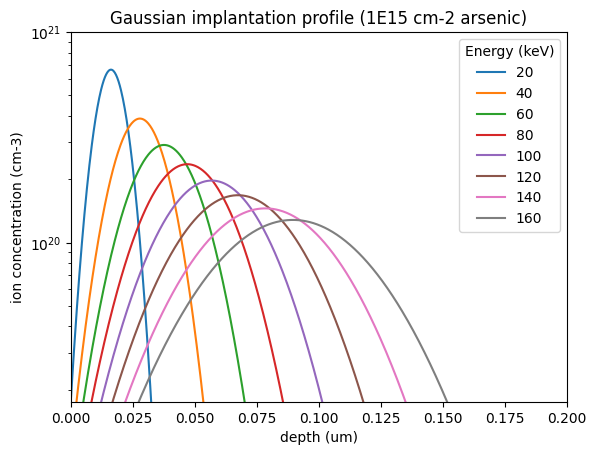

In [4]:
energies = [20, 40, 60, 80, 100, 120, 140, 160]
z = np.linspace(0, 0.25, 1000)

import matplotlib.pyplot as plt

lower_lim = 0
for E in energies:
    c = silicon_gaussian_profile("arsenic", dose=1e15, E=E, z=z)
    plt.semilogy(z, c, label=E)
    if c[0] > lower_lim:
        lower_lim = c[0]

plt.xlabel("depth (um)")
plt.ylabel("ion concentration (cm-3)")
plt.ylim([lower_lim, 1e21])
plt.xlim([0, 0.2])
plt.title("Gaussian implantation profile (1E15 cm-2 arsenic)")
plt.legend(title="Energy (keV)")

## Skewed Gaussian profile

For more realistic results with nonzero skewness (we catalog the skews of [1], but your mileage may vary), two half-gaussians can better approximate the distribution:

Text(0.5, 1.0, 'Ion implantation in silicon, skewness')

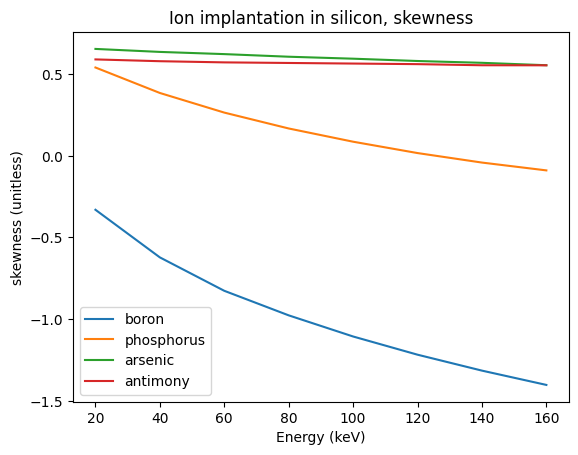

In [5]:
for dopant in ["boron", "phosphorus", "arsenic", "antimony"]:
    plt.plot(energies, skew_in_silicon[dopant](energies), label=dopant)

plt.xlabel("Energy (keV)")
plt.ylabel("skewness (unitless)")
plt.legend(loc="best")
plt.title("Ion implantation in silicon, skewness")

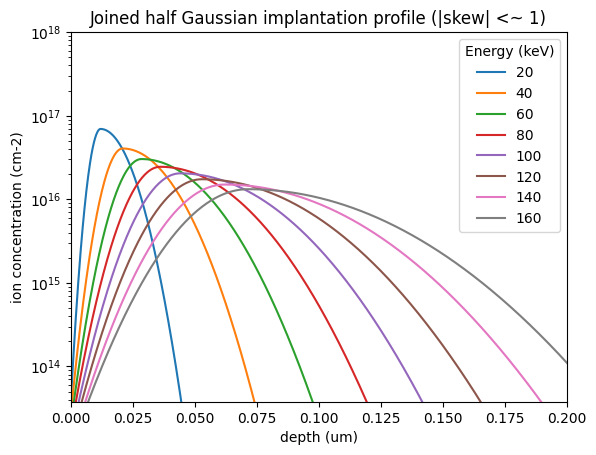

In [6]:
energies = [20, 40, 60, 80, 100, 120, 140, 160]
z = np.linspace(0, 0.25, 1000)

import matplotlib.pyplot as plt

lower_lim = 0
for E in energies:
    c = silicon_skewed_gaussian_profile("arsenic", dose=1e11, E=E, z=z)
    plt.semilogy(z, c, label=E)
    if c[0] > lower_lim:
        lower_lim = c[0]

plt.xlabel("depth (um)")
plt.ylabel("ion concentration (cm-2)")
plt.ylim([lower_lim, 1e18])
plt.xlim([0, 0.2])
plt.title("Joined half Gaussian implantation profile (|skew| <~ 1)")
plt.legend(title="Energy (keV)")

The above can be further improved by considering a Pearson IV distribution, or performing Monte-Carlo simulations of implantation.

## Diffusion

Thermal treatment of the wafer to anneal implantation defects and activate the dopants results in rearrangement of the doping ions, and hence a change in doping profile. This is governed by the diffusivity of the species in the crystal:

In [7]:
from gdsfactory.simulation.process.diffusion import *
from gdsfactory.simulation.process.silicon import ni

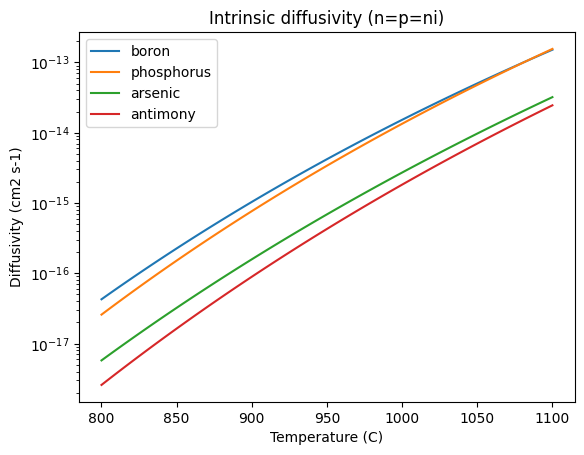

In [8]:
Ts = np.linspace(800, 1100, 100)

for dopant in ["boron", "phosphorus", "arsenic", "antimony"]:
    plt.semilogy(Ts, D(dopant, Ts), label=dopant)

plt.xlabel("Temperature (C)")
plt.ylabel("Diffusivity (cm2 s-1)")
plt.title("Intrinsic diffusivity (n=p=ni)")
plt.legend()

In this low-doping regime, the diffusivity can be taken as constant, and there exist an analytical solution for initially Gaussian doping profiles:

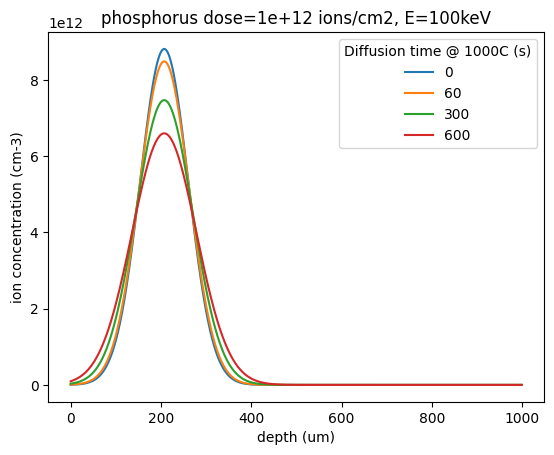

In [9]:
T = 1000  # C
dopant = "phosphorus"
dose = 1e12  # ions/cm2
E = 100  # keV
z = np.linspace(0, 0.6, 1000)

for t in [0, 60, 5 * 60, 10 * 60]:
    conc = silicon_diffused_gaussian_profile(
        dopant=dopant,
        dose=dose,
        E=E,
        t=t,
        T=T,
        z=z,
    )
    plt.plot(conc, label=t)
plt.title(f"{dopant} dose={dose:1.0e} ions/cm2, E={E}keV")
plt.xlabel("depth (um)")
plt.ylabel("ion concentration (cm-3)")
plt.legend(title=f"Diffusion time @ {T}C (s)")
plt.show()

This can be extended to many dimensions.

### Concentration-dependent diffusion

In general, especially at higher concentrations, diffusivity depends on concentration:

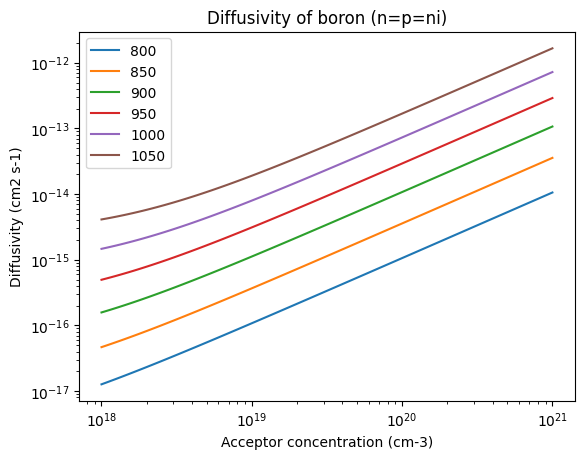

In [10]:
Ts = [800, 850, 900, 950, 1000, 1050]
conc = np.logspace(18, 21, 100)

for T in Ts:
    plt.loglog(conc, D("boron", T, n=conc, p=conc), label=T)

plt.xlabel("Acceptor concentration (cm-3)")
plt.ylabel("Diffusivity (cm2 s-1)")
plt.title("Diffusivity of boron (n=p=ni)")
plt.legend()

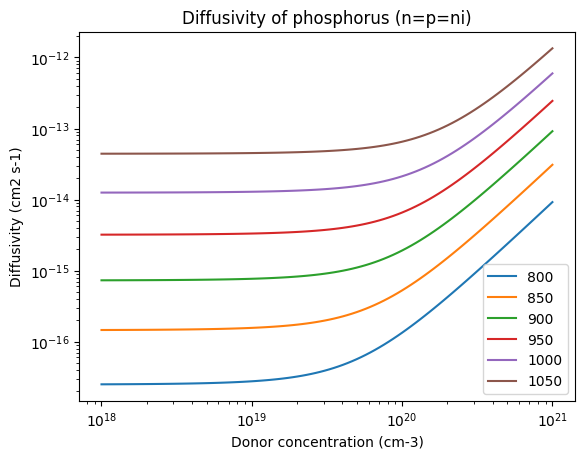

In [11]:
for T in Ts:
    plt.loglog(conc, D("phosphorus", T, n=conc, p=conc), label=T)

plt.xlabel("Donor concentration (cm-3)")
plt.ylabel("Diffusivity (cm2 s-1)")
plt.title("Diffusivity of phosphorus (n=p=ni)")
plt.legend()

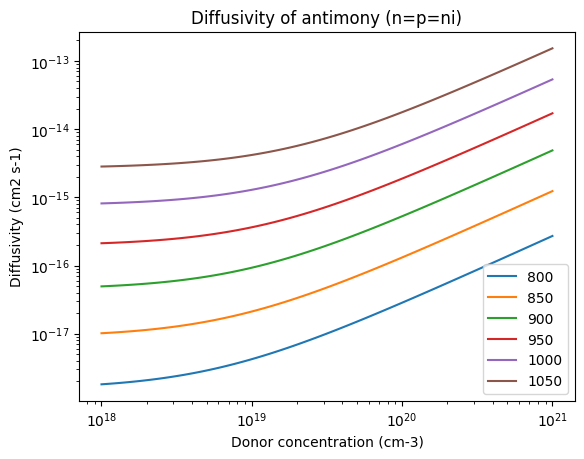

In [12]:
for T in Ts:
    plt.loglog(conc, D("antimony", T, n=conc, p=conc), label=T)

plt.xlabel("Donor concentration (cm-3)")
plt.ylabel("Diffusivity (cm2 s-1)")
plt.title("Diffusivity of antimony (n=p=ni)")
plt.legend()

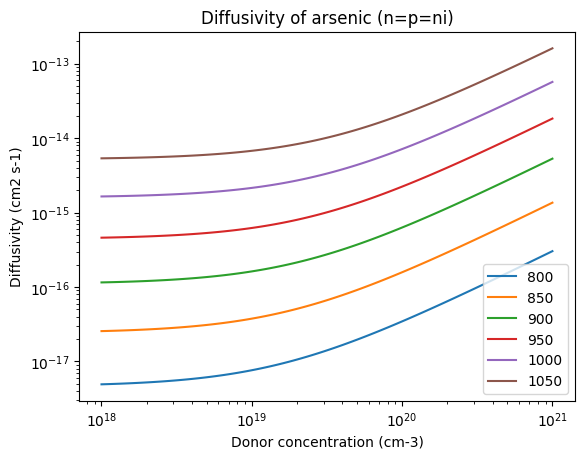

In [13]:
for T in Ts:
    plt.loglog(conc, D("arsenic", T, n=conc, p=conc), label=T)

plt.xlabel("Donor concentration (cm-3)")
plt.ylabel("Diffusivity (cm2 s-1)")
plt.title("Diffusivity of arsenic (n=p=ni)")
plt.legend()

The most generic solution considers the local forms of these concentration-dependent diffusivities for the diffusion equation of each dopant, as well as the electrostatic potential, in a finite-element scheme.